## Dataset

This project uses the dataset from the Kaggle competition:

🔗 https://www.kaggle.com/competitions/rsna-intracranial-aneurysm-detection

**The dataset is not included in this repository** due to competition rules.  
Please download it directly from Kaggle after accepting the competition terms.

You can download the data using Kaggle CLI:


kaggle competitions download -c rsna-intracranial-aneurysm-detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import TensorDataset, DataLoader, Dataset
import copy
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from time import perf_counter
from transformers import AutoModel
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
label2organ = {
  1: "Other Posterior Circulation",
  2: "Basilar Tip",
  3: "Right Posterior Communicating Artery",
  4: "Left Posterior Communicating Artery",
  5: "Right Infraclinoid Internal Carotid Artery",
  6: "Left Infraclinoid Internal Carotid Artery",
  7: "Right Supraclinoid Internal Carotid Artery",
  8: "Left Supraclinoid Internal Carotid Artery",
  9: "Right Middle Cerebral Artery",
  10: "Left Middle Cerebral Artery",
  11: "Right Anterior Cerebral Artery",
  12: "Left Anterior Cerebral Artery",
  13: "Anterior Communicating Artery"
}

In [121]:
class STN(nn.Module):
    def __init__(self, input_channels=10, output_size=(224, 224)):
        super(STN, self).__init__()

        self.output_size = output_size
        self.slice_start = max(0, -(input_channels - 10))
        self.read_theta = False
        
        self.localization = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),

            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, 6),
        )
        
        self.fc_loc[-1].weight.data.zero_()
        self.fc_loc[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = x[:, self.slice_start:, :, :]
        xs = self.localization(xs)
        xs = xs.view(-1, 64 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        if self.read_theta:
            print(f'Theta: {theta}')

        target_shape = torch.Size([x.shape[0], x.shape[1], self.output_size[0], self.output_size[1]])
        
        grid = F.affine_grid(theta, target_shape, align_corners=False)
        
        x_transformed = F.grid_sample(x, grid, align_corners=False)
        
        return x_transformed

class AneurysmClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, output_size=(224, 224), stn_only_on_seg=False):
        super(AneurysmClassifier, self).__init__()

        self.stn = STN(5, output_size) if stn_only_on_seg else STN(in_channels, output_size)
        weights = ResNet50_Weights.DEFAULT
        self.resnet = resnet50(weights=weights)

        '''for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True'''
        
        for name, layer in self.resnet.named_children():
            if name in ('layer4', 'fc'):
                layer.trainable = True
            else:
                layer.trainable = False

        self.resnet.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.stn(x)
        x = self.resnet(x)
        return x
    
class AneurysmClassifierDINO(nn.Module):

    def __init__(self, in_channels, num_classes, output_size=(224, 224), stn_only_on_seg=False):
        super().__init__()

        self.stn = STN(5, output_size) if stn_only_on_seg else STN(in_channels, output_size)
        self.dino = AutoModel.from_pretrained("facebook/dinov2-base")

        for param in self.dino.parameters():
            param.requires_grad = False

        self.prepare_to_dino = nn.Conv2d(in_channels, 3, kernel_size=1)

        self.clf = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stn(x)
        x = self.prepare_to_dino(x)
        outputs = self.dino(pixel_values=x)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.clf(x)
        return x

In [4]:
class MedicalDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
def visualize_stn(model, input_img, device, channels=range(10)):
    model.stn.read_theta = True
    model.eval()
    with torch.no_grad():
        input_img = input_img.to(device)
        stn_output = model.stn(input_img)

        input_img = input_img.cpu().numpy().squeeze(0)
        stn_output = stn_output.cpu().numpy().squeeze(0)

    fig, axes = plt.subplots(2, len(channels), figsize=(len(channels) * 5, 10))
        
    for i, channel in enumerate(channels):
        cmap = 'gray' if channel < 5 else None

        axes[0, i].imshow(input_img[channel, :, :], cmap=cmap)
        axes[1, i].imshow(stn_output[channel, :, :], cmap=cmap)

        axes[0, i].axis('off')
        axes[1, i].axis('off')

        axes[0, i].set_title(f'Original: {channel}')
        axes[1, i].set_title(f'STN: {channel}')

    model.stn.read_theta = False
    plt.show()

def evaluate_model(model, device, loader):
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).squeeze()

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            y_pred.extend(pred.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)

    plt.show()

In [9]:
train_folder = Path('C:/Users/dawid/OneDrive/Pulpit/aneurysm classifier/data/train')
test_folder = Path('C:/Users/dawid/OneDrive/Pulpit/aneurysm classifier/data/test')

In [10]:
x_train = np.load(os.path.join(train_folder, 'train_images.npy'))
y_train = np.load(os.path.join(train_folder, 'train_labels.npy'))
x_test = np.load(os.path.join(test_folder, 'test_images.npy'))
y_test = np.load(os.path.join(test_folder, 'test_labels.npy'))

In [11]:
bin_x_train = np.copy(x_train)
bin_y_train = np.copy(y_train)
bin_y_test = np.copy(y_test)

aneurysm_train_mask = np.where(y_train > 0)[0]
aneurysm_test_mask = np.where(y_test > 0)[0]
bin_y_train[aneurysm_train_mask] = 1
bin_y_test[aneurysm_test_mask] = 1

In [12]:
aneurysm_mask = np.where(y_train > 0)[0]
healthy_mask = np.where(y_train == 0)[0]

aneurysm_x = x_train[aneurysm_mask]
healthy_x = x_train[healthy_mask]
aneurysm_y = y_train[aneurysm_mask]
healthy_y = y_train[healthy_mask]

aneurysm_x = np.repeat(aneurysm_x, 10, axis=0)
aneurysm_y = np.repeat(aneurysm_y, 10, axis=0)

x_train = np.concatenate([aneurysm_x, healthy_x], axis=0)
y_train = np.concatenate([aneurysm_y, healthy_y], axis=0)

In [13]:
np.bincount(y_train.squeeze().astype(int))

array([203, 230, 100,  60,  60,  60,  60, 180, 170, 160,  80, 110,  10,
       330], dtype=int64)

In [14]:
np.bincount(bin_y_train[:, 0].astype(int))

array([203, 161], dtype=int64)

In [15]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

x_train_tensor = x_train_tensor.permute(0, -1, 1, 2)
x_test_tensor = x_test_tensor.permute(0, -1, 1, 2)

In [16]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
])

In [17]:
train_dataset = MedicalDataset(x_train_tensor, y_train_tensor, train_transform)
test_dataset = MedicalDataset(x_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
bin_x_train_tensor = torch.from_numpy(bin_x_train).float()
bin_y_train_tensor = torch.from_numpy(bin_y_train).long()

bin_x_test_tensor = torch.from_numpy(x_test).float()
bin_y_test_tensor = torch.from_numpy(bin_y_test).long()

bin_x_train_tensor = bin_x_train_tensor.permute(0, -1, 1, 2)
bin_x_test_tensor = bin_x_test_tensor.permute(0, -1, 1, 2)

bin_train_dataset = MedicalDataset(bin_x_train_tensor, bin_y_train_tensor, train_transform)
bin_test_dataset = MedicalDataset(bin_x_test_tensor, bin_y_test_tensor)

batch_size = 32

bin_train_loader = DataLoader(bin_train_dataset, batch_size, shuffle=True)
bin_test_loader = DataLoader(bin_test_dataset, batch_size, shuffle=False)

BINARY MODEL

In [72]:
num_epochs = 8
lr = 1e-3

bin_model = AneurysmClassifier(in_channels=10, num_classes=2)
bin_model.to(device)

stn_params = [p for p in bin_model.stn.parameters() if p.requires_grad]
resnet_params = [p for p in bin_model.resnet.parameters() if p.requires_grad]

params = [p for p in bin_model.stn.parameters() if p.requires_grad]

bin_optimizer = torch.optim.Adam(params=params, lr=lr)

class_weights = torch.tensor([y_train.shape[0] / count for count in np.bincount(bin_y_train_tensor[:,0])], dtype=torch.float32, device=device)
class_weights[1] *= 1.1
bin_criterion = nn.CrossEntropyLoss(weight=class_weights)

BINARY CLASSIFICATION

In [73]:
start = perf_counter()

lowest_loss = 1000
best_model_weights = {k: v.cpu() for k, v in bin_model.state_dict().items()}

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1} / {num_epochs}')

    for mode in ('train', 'val'):
        if mode == 'train':
            dataloader = bin_train_loader
            bin_model.train()
        else:
            dataloader = bin_test_loader
            bin_model.eval()

        running_loss = 0.0
        running_corrects = 0.0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs =  inputs.to(device)
            labels = labels.to(device)

            bin_optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                outputs = bin_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = bin_criterion(outputs, labels.squeeze())

                if mode == 'train':
                    loss.backward()
                    bin_optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels.squeeze()).sum().item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        print(f'Loss: {epoch_loss}, accuracy: {epoch_acc}')

        if mode == 'val' and epoch_loss < lowest_loss:
            print(f'New lowest loss. Epoch {epoch+1}')
            lowest_loss = epoch_loss
            best_model_weights = {k: v.cpu() for k, v in bin_model.state_dict().items()}

end = perf_counter()
print(f'Learning time: {end - start}')

Epoch: 1 / 8
Loss: 0.7009542237271319, accuracy: 0.4697802197802198
Loss: 0.70222690144738, accuracy: 0.4175824175824176
New lowest loss. Epoch 1
Epoch: 2 / 8
Loss: 0.6952848329648866, accuracy: 0.4423076923076923
Loss: 0.692265686753032, accuracy: 0.43956043956043955
New lowest loss. Epoch 2
Epoch: 3 / 8
Loss: 0.6969210708534325, accuracy: 0.45604395604395603
Loss: 0.6913262016170627, accuracy: 0.45054945054945056
New lowest loss. Epoch 3
Epoch: 4 / 8
Loss: 0.699648162820837, accuracy: 0.4423076923076923
Loss: 0.689027746955117, accuracy: 0.5604395604395604
New lowest loss. Epoch 4
Epoch: 5 / 8
Loss: 0.6988980914210225, accuracy: 0.45054945054945056
Loss: 0.6935562720665565, accuracy: 0.4175824175824176
Epoch: 6 / 8
Loss: 0.6959149202147683, accuracy: 0.47527472527472525
Loss: 0.6942935710424906, accuracy: 0.5714285714285714
Epoch: 7 / 8
Loss: 0.6947195353088799, accuracy: 0.4478021978021978
Loss: 0.6983456971881153, accuracy: 0.42857142857142855
Epoch: 8 / 8
Loss: 0.6961067174817179,

BINARY MODEL EVALUATION

In [74]:
bin_model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [23]:
torch.save(bin_model.state_dict(), 'Bin_Resnet50_seg.pth')

              precision    recall  f1-score   support

           0       0.87      0.25      0.39        51
           1       0.50      0.95      0.66        40

    accuracy                           0.56        91
   macro avg       0.68      0.60      0.52        91
weighted avg       0.71      0.56      0.51        91



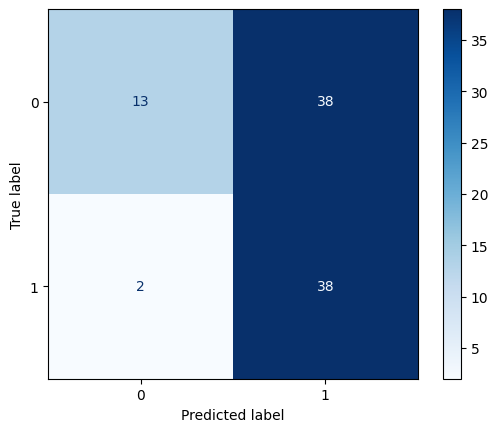

In [75]:
evaluate_model(bin_model, device, bin_test_loader)

In [76]:
def get_idx():
    idx = -1
    while True:
        idx += 1
        yield idx

idx_gen = get_idx()
bin_idx_gen = get_idx()
bin_dino_idx = get_idx()

Theta: tensor([[[ 0.4431,  0.0407,  0.0855],
         [-0.1750,  0.1619, -0.1566]]], device='cuda:0')


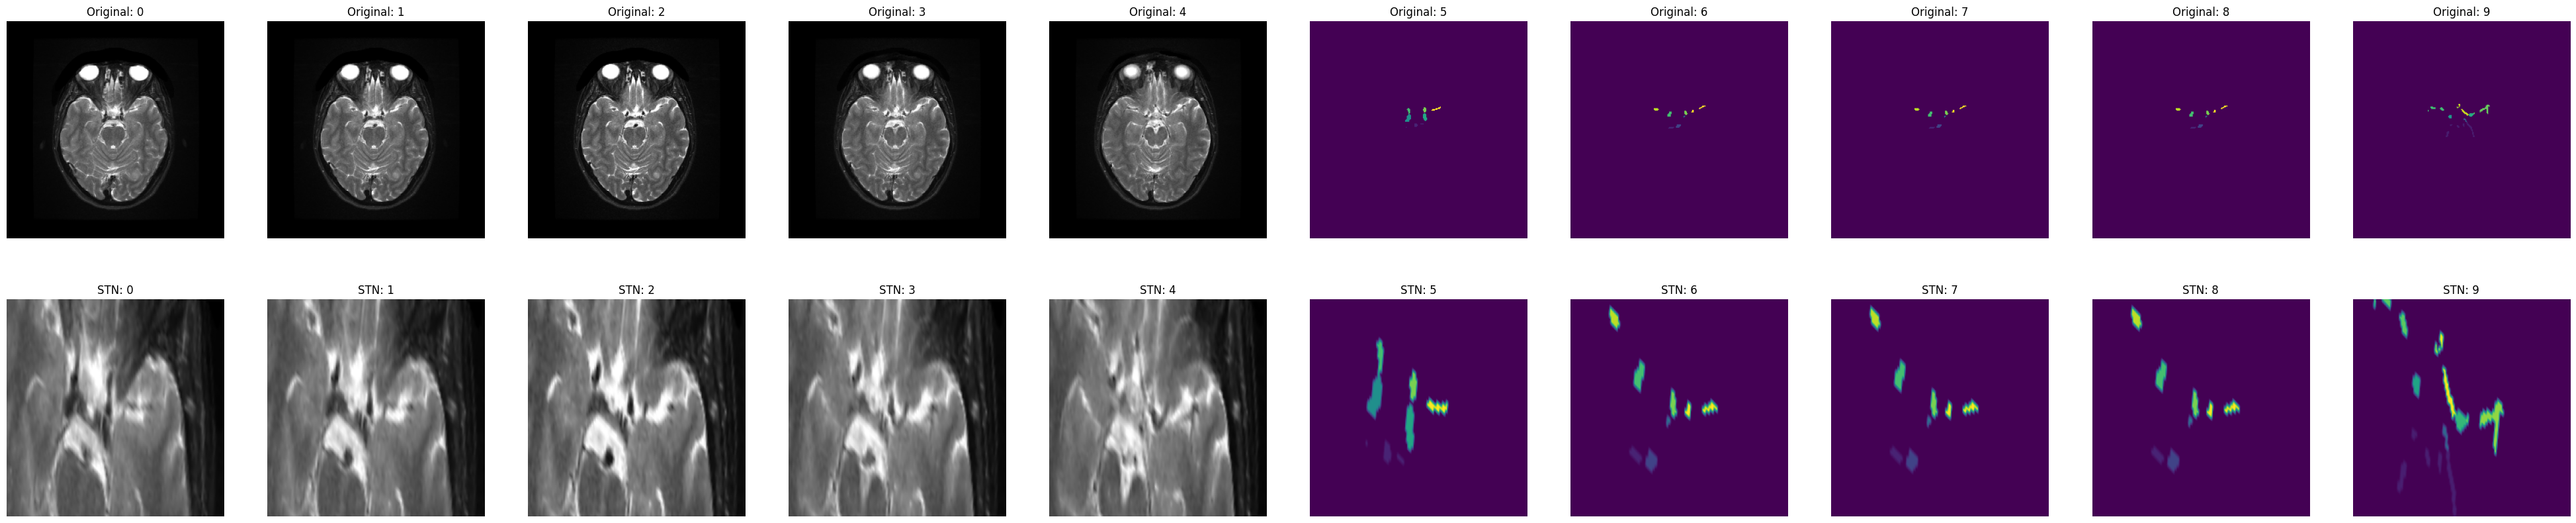

In [77]:
bin_train_loader.dataset.transform = None

for input, _ in bin_train_loader:
    visualize_stn(bin_model, input[0].unsqueeze(0), device,)
    break

0
Theta: tensor([[[ 0.4431,  0.0407,  0.0855],
         [-0.1750,  0.1619, -0.1566]]], device='cuda:0')


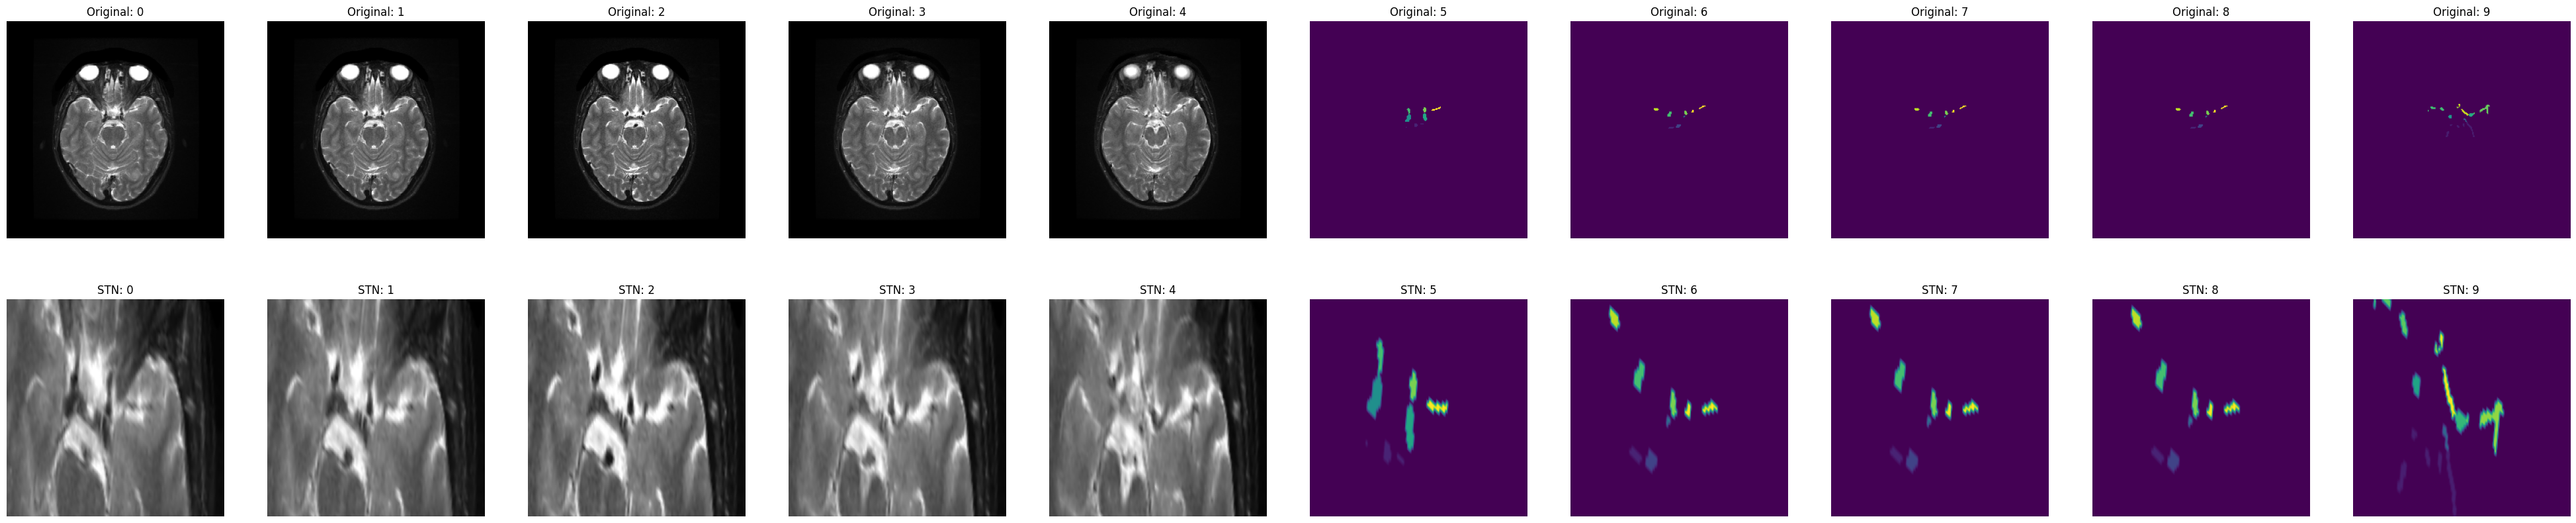

In [78]:
bin_idx = next(bin_idx_gen)
print(bin_idx)
visualize_stn(bin_model, input[bin_idx].unsqueeze(0), device)

Theta: tensor([[[ 1.0037e+00,  2.9643e-03,  3.2838e-03],
         [-5.4220e-03,  9.8948e-01,  5.9003e-04]]], device='cuda:0')


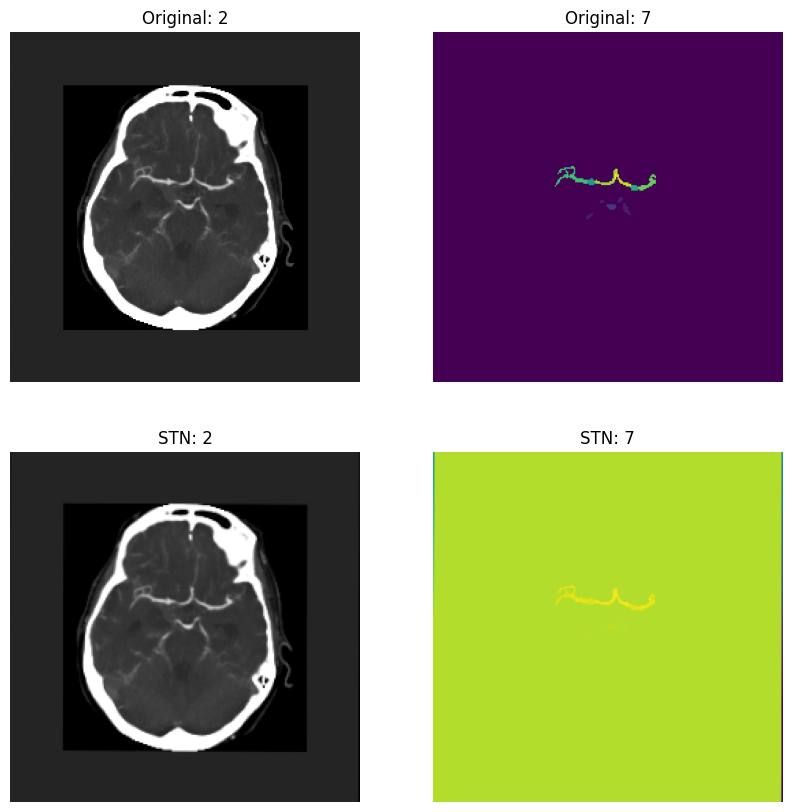

In [59]:
visualize_stn(bin_model, input[bin_idx].unsqueeze(0), device, (2, 7))

MULTICLASS CLASSIFICATION MODEL

In [109]:
num_epochs = 8
resnet_lr = 1e-4
stn_lr = 1e-4

model = AneurysmClassifier(in_channels=10, num_classes=14)
model.to(device)

stn_params = [p for p in model.stn.parameters() if p.requires_grad]
resnet_params = [p for p in model.resnet.parameters() if p.requires_grad]

optimizer = torch.optim.Adam([
    {'params' : stn_params, 'lr' : stn_lr}, 
    {'params' : resnet_params, 'lr' : resnet_lr},
    ])

class_weights = torch.tensor([y_train.shape[0] / count for count in np.bincount(y_train_tensor[:,0])], dtype=torch.float32, device=device)
#class_weights[1:] *= 1.1
criterion = nn.CrossEntropyLoss(weight=class_weights)

MULTICLASS CLASSIFICATION

In [110]:
start = perf_counter()

lowest_loss = 1000
best_model_weights = {k: v.cpu() for k, v in bin_model.state_dict().items()}

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1} / {num_epochs}')

    for mode in ('train', 'val'):
        if mode == 'train':
            dataloader = train_loader
            model.train()
        else:
            dataloader = test_loader
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs =  inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.squeeze())

                if mode == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels.squeeze()).sum().item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        print(f'Loss: {epoch_loss}, accuracy: {epoch_acc}')

        if mode == 'val' and epoch_loss < lowest_loss:
            print(f'New lowest loss. Epoch {epoch+1}')
            lowest_loss = epoch_loss
            best_model_weights = copy.deepcopy(model.state_dict())

end = perf_counter()
print(f'Learning time: {end - start}')

Epoch: 1 / 8
Loss: 2.4054207133773406, accuracy: 0.1969111969111969
Loss: 2.6046324850438713, accuracy: 0.054945054945054944
New lowest loss. Epoch 1
Epoch: 2 / 8
Loss: 1.5368682187496465, accuracy: 0.44346387203530063
Loss: 2.5723666751777734, accuracy: 0.07692307692307693
New lowest loss. Epoch 2
Epoch: 3 / 8
Loss: 0.8234303413473698, accuracy: 0.6878102592388307
Loss: 2.5355298938332025, accuracy: 0.16483516483516483
New lowest loss. Epoch 3
Epoch: 4 / 8
Loss: 0.44567084595174733, accuracy: 0.8295642581356867
Loss: 2.6353791519835754, accuracy: 0.27472527472527475
Epoch: 5 / 8
Loss: 0.2424301451582706, accuracy: 0.8996138996138996
Loss: 2.7897832681844523, accuracy: 0.32967032967032966
Epoch: 6 / 8
Loss: 0.14298307797853552, accuracy: 0.9442912300055157
Loss: 2.8043506119277453, accuracy: 0.4175824175824176
Epoch: 7 / 8
Loss: 0.1415814495569951, accuracy: 0.9542195256480971
Loss: 2.6060126286286573, accuracy: 0.3956043956043956
Epoch: 8 / 8
Loss: 0.10049092791814272, accuracy: 0.965

In [112]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [40]:
torch.save(model.state_dict(), 'multiclass__resnet50.pth')

              precision    recall  f1-score   support

           0       0.44      0.14      0.21        51
           1       0.17      0.17      0.17         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.12      0.50      0.20         2
           6       0.25      0.50      0.33         2
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       1.00      0.50      0.67         2
          11       0.08      0.33      0.13         3
          13       0.25      0.38      0.30         8

    accuracy                           0.16        91
   macro avg       0.18      0.19      0.15        91
weighted avg       0.31      0.16      0.19        91



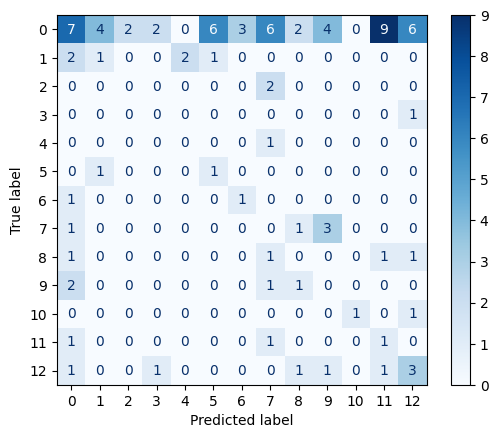

In [113]:
evaluate_model(model, device, test_loader)

Theta: tensor([[[ 2.4779e-01, -3.1433e-03, -9.1357e-04],
         [-1.0890e-04,  2.4840e-01,  3.3269e-04]]], device='cuda:0')


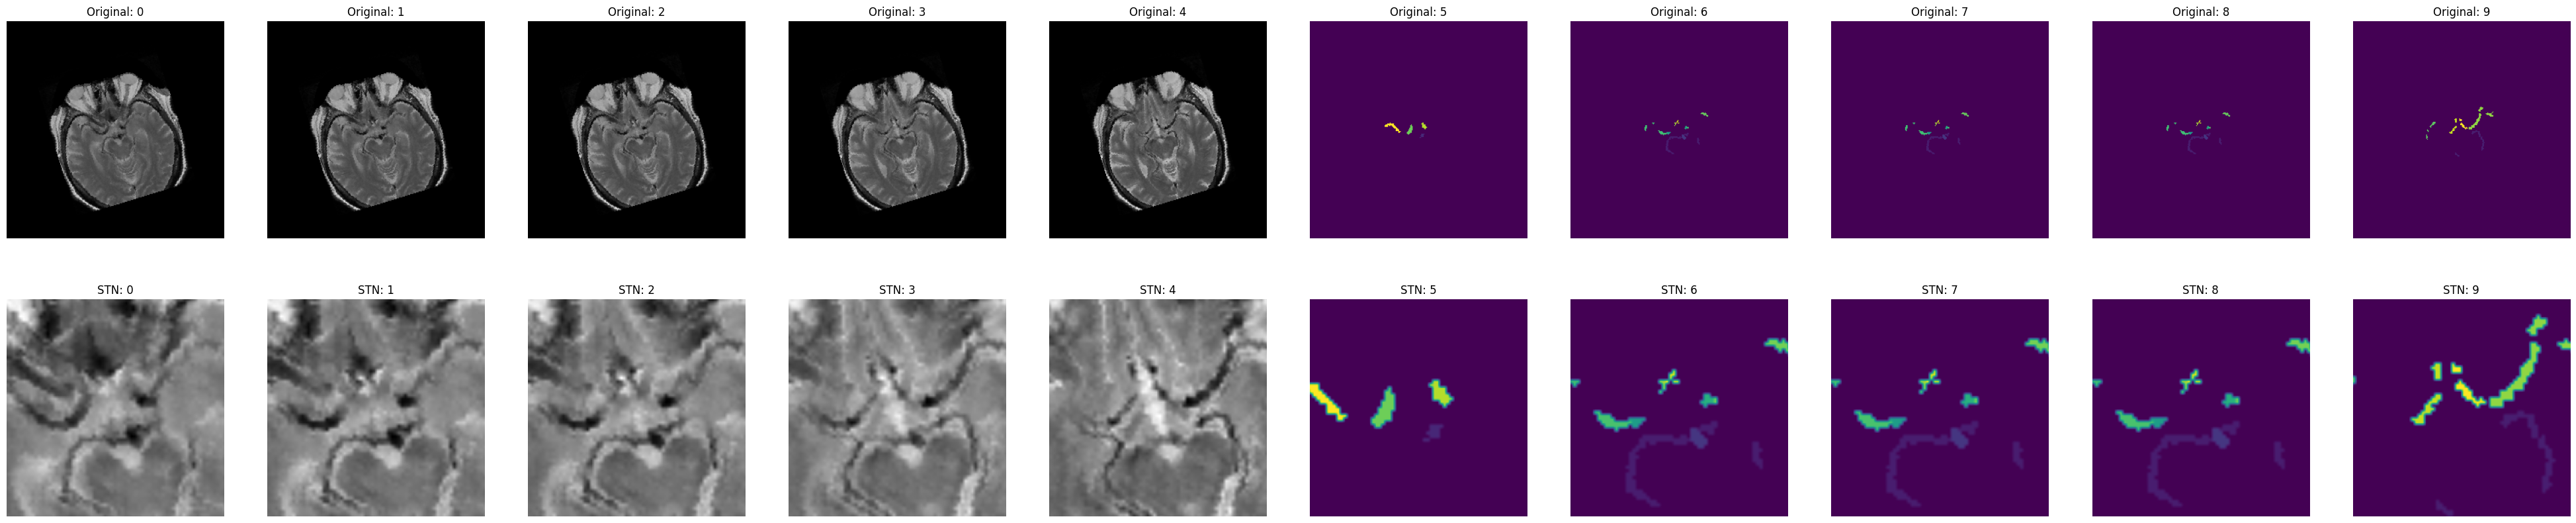

In [114]:
for input, label in train_loader:
    visualize_stn(model, input[0].unsqueeze(0), device,)
    break

8
Theta: tensor([[[ 2.4784e-01, -3.0707e-03, -8.6314e-04],
         [-9.8456e-05,  2.4844e-01,  3.1173e-04]]], device='cuda:0')


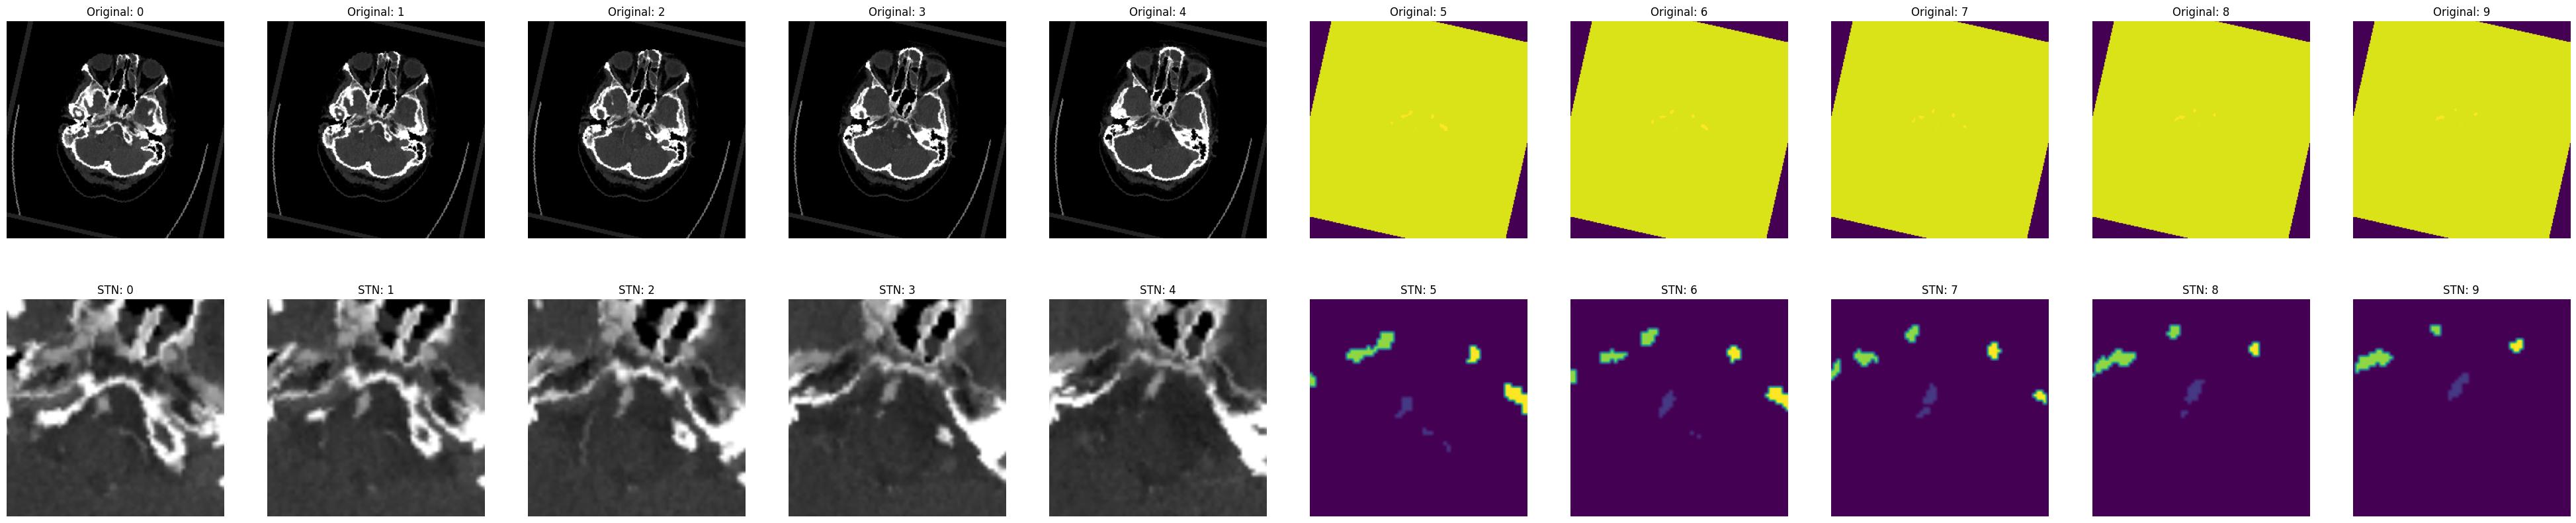

In [118]:
idx = next(idx_gen)
print(idx)
visualize_stn(model, input[idx].unsqueeze(0), device)

Theta: tensor([[[ 2.4784e-01, -3.0707e-03, -8.6314e-04],
         [-9.8456e-05,  2.4844e-01,  3.1173e-04]]], device='cuda:0')


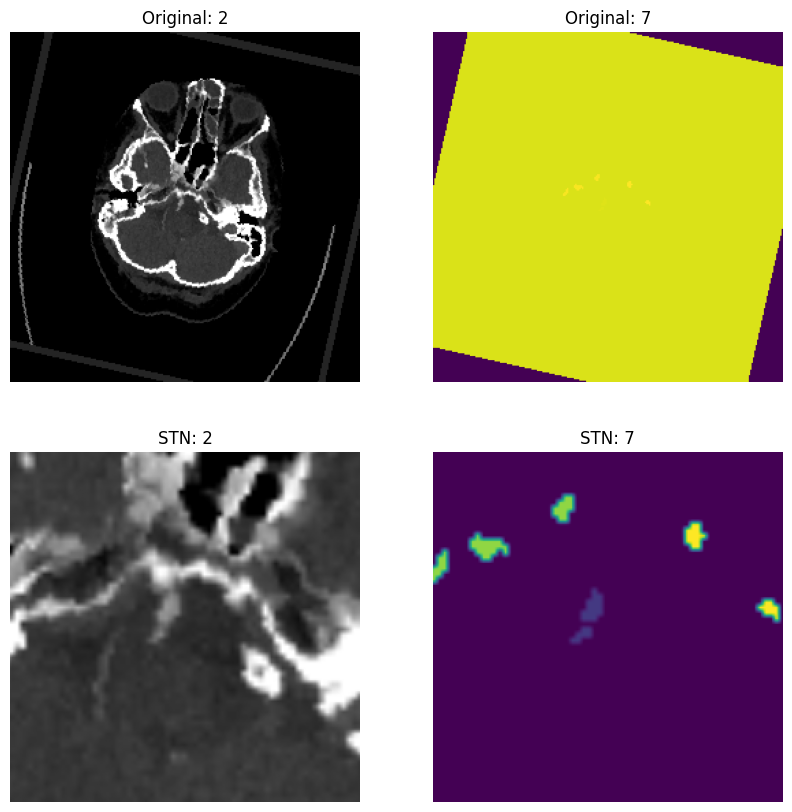

tensor([1])

In [119]:
visualize_stn(model, input[idx].unsqueeze(0), device, (2, 7))
label[idx]

BINARY DINO

In [66]:
num_epochs = 8
lr = 1e-4

bin_dino = AneurysmClassifierDINO(in_channels=10, num_classes=2)
bin_dino.to(device)

params = [p for p in bin_dino.parameters() if p.requires_grad]

bin_dino_optimizer = torch.optim.AdamW(params, lr)

class_weights = torch.tensor([y_train.shape[0] / count for count in np.bincount(bin_y_train_tensor[:,0])], dtype=torch.float32, device=device)
#class_weights[1] *= 1.1
bin_dino_criterion = nn.CrossEntropyLoss(weight=class_weights)

Loading weights:   0%|          | 0/223 [00:00<?, ?it/s]

In [67]:
start = perf_counter()

lowest_loss = 1000
best_model_weights = {k: v.cpu() for k, v in bin_dino.state_dict().items()}

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1} / {num_epochs}')

    for mode in ('train', 'val'):
        if mode == 'train':
            dataloader = bin_train_loader
            bin_dino.train()
        else:
            dataloader = bin_test_loader
            bin_dino.eval()

        running_loss = 0.0
        running_corrects = 0.0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs =  inputs.to(device)
            labels = labels.to(device)

            bin_dino_optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                outputs = bin_dino(inputs)
                _, preds = torch.max(outputs, 1)
                loss = bin_dino_criterion(outputs, labels.squeeze())

                if mode == 'train':
                    loss.backward()
                    bin_dino_optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels.squeeze()).sum().item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        print(f'Loss: {epoch_loss}, accuracy: {epoch_acc}')

        if mode == 'val' and epoch_loss < lowest_loss:
            print(f'New lowest loss. Epoch {epoch+1}')
            lowest_loss = epoch_loss
            best_model_weights = {k: v.cpu() for k, v in bin_dino.state_dict().items()}

end = perf_counter()
print(f'Learning time: {end - start}')

Epoch: 1 / 8
Loss: 0.7428032991650341, accuracy: 0.45604395604395603
Loss: 0.6676622923913893, accuracy: 0.6703296703296703
New lowest loss. Epoch 1
Epoch: 2 / 8
Loss: 0.7002942018456512, accuracy: 0.510989010989011
Loss: 0.6853262238450103, accuracy: 0.4835164835164835
Epoch: 3 / 8
Loss: 0.6915929016176161, accuracy: 0.5384615384615384
Loss: 0.6867560940784413, accuracy: 0.5384615384615384
Epoch: 4 / 8
Loss: 0.685674080481896, accuracy: 0.5796703296703297
Loss: 0.6792132618663075, accuracy: 0.5274725274725275
Epoch: 5 / 8
Loss: 0.665403622847337, accuracy: 0.5879120879120879
Loss: 0.6957801305330716, accuracy: 0.4945054945054945
Epoch: 6 / 8
Loss: 0.6517365555186848, accuracy: 0.6373626373626373
Loss: 0.6746992331284744, accuracy: 0.5714285714285714
Epoch: 7 / 8
Loss: 0.6383702650174989, accuracy: 0.6428571428571429
Loss: 0.6946278836700942, accuracy: 0.4835164835164835
Epoch: 8 / 8
Loss: 0.6403379898804885, accuracy: 0.6373626373626373
Loss: 0.6809787756794101, accuracy: 0.5274725274

EVALUATE BINARY DINO

In [45]:
bin_dino.load_state_dict(best_model_weights)

<All keys matched successfully>

In [44]:
torch.save(bin_dino.state_dict(), 'bin_dino.pth')

              precision    recall  f1-score   support

           0       0.57      0.67      0.61        51
           1       0.45      0.35      0.39        40

    accuracy                           0.53        91
   macro avg       0.51      0.51      0.50        91
weighted avg       0.52      0.53      0.52        91



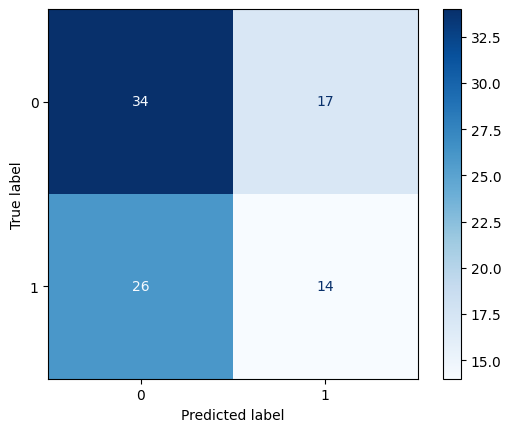

In [68]:
evaluate_model(bin_dino, device, bin_test_loader)

Theta: tensor([[[ 1.0020e+00, -1.0561e-03,  5.0950e-04],
         [-1.7758e-03,  1.0005e+00,  4.5038e-04]]], device='cuda:0')


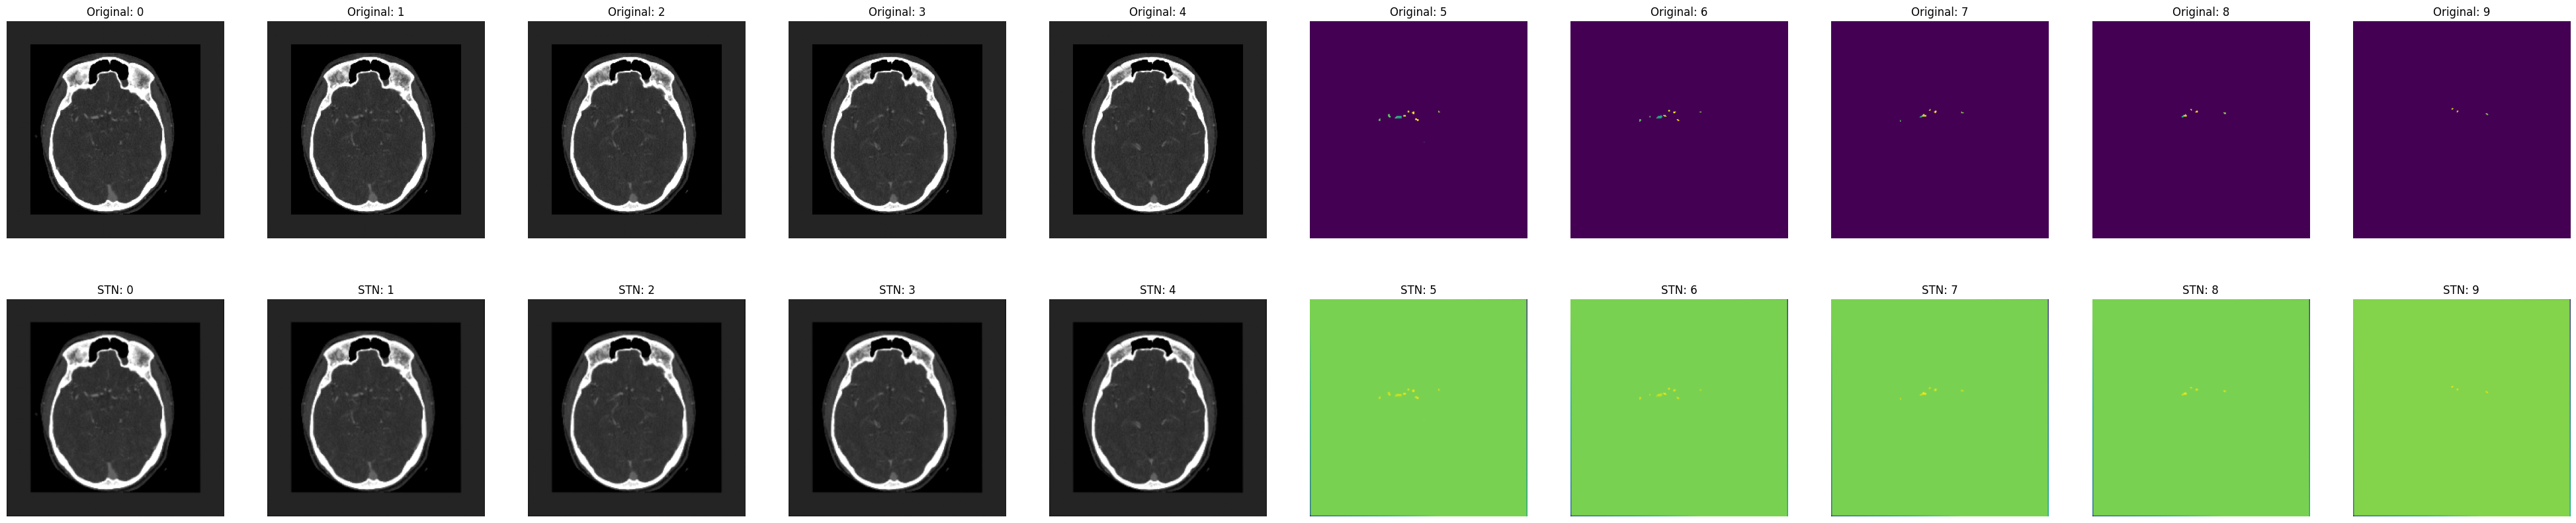

In [69]:
bin_train_loader.dataset.transform = None

for input, label in bin_train_loader:
    visualize_stn(bin_dino, input[0].unsqueeze(0), device,)
    break

0
Theta: tensor([[[ 1.0020e+00, -1.0561e-03,  5.0950e-04],
         [-1.7758e-03,  1.0005e+00,  4.5038e-04]]], device='cuda:0')


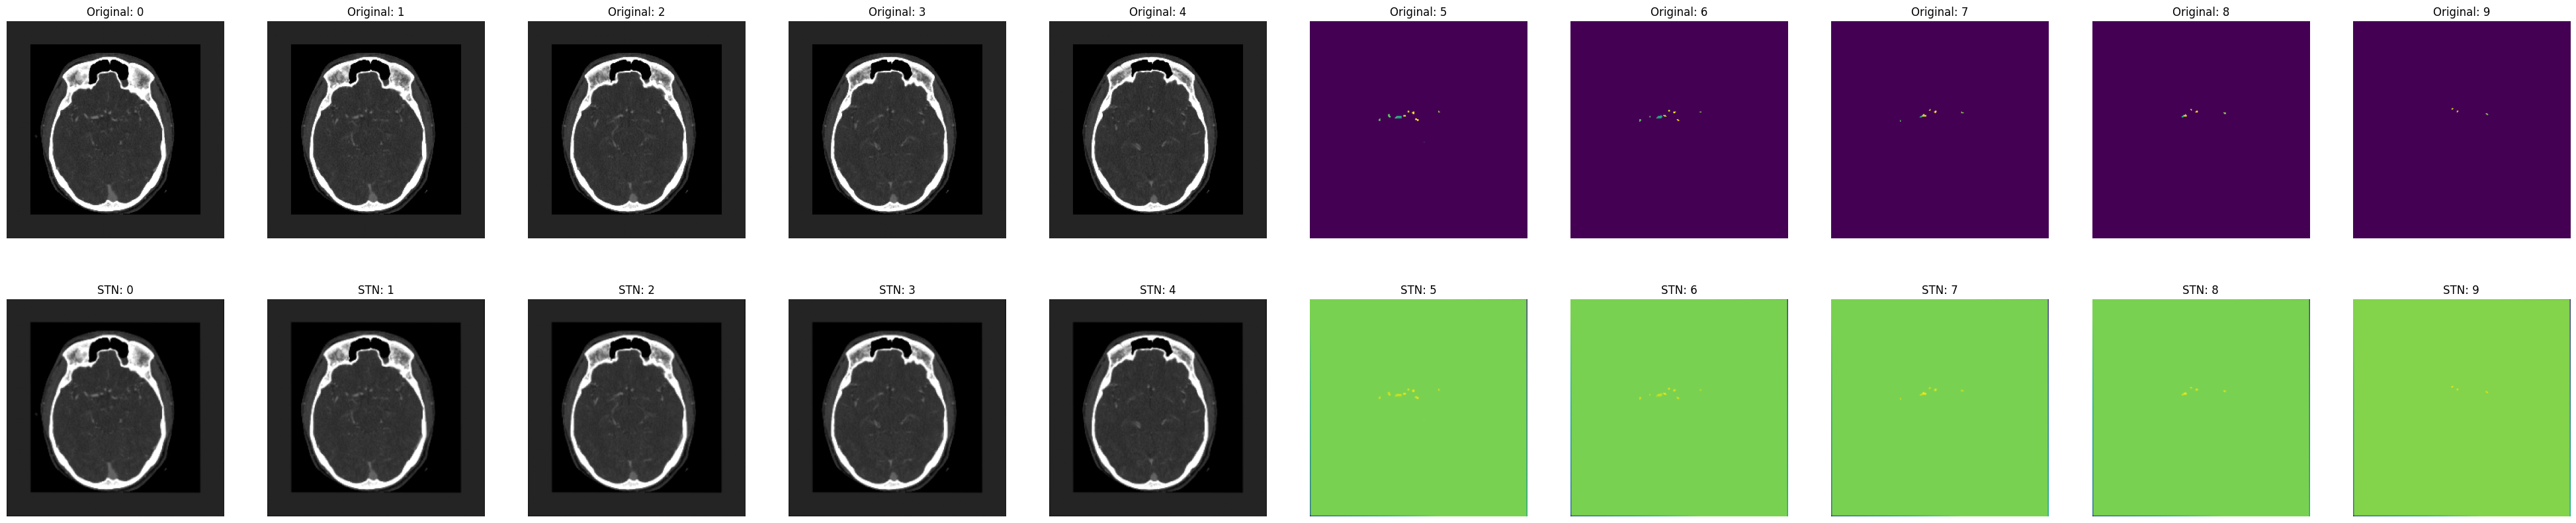

In [70]:

idx = next(bin_dino_idx)
print(idx)
visualize_stn(bin_dino, input[idx].unsqueeze(0), device)